<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
<center>Author: [Mariya Mansurova](https://www.linkedin.com/in/mariya-mansurova-04070982/), analyst & developer in Yandex.Metrics team. <br>Translated by [Ivan Zakharov](https://www.linkedin.com/in/ivan-zakharov/), ML enthusiast.
<br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #9 (demo)
## <center> Time series analysis

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

3.4.1


## Data preparation

In [2]:
df = pd.read_csv('../input/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426
- 5229
- 2744

In [8]:
train_df = df[:-predictions].copy()
m = Prophet()
m.fit(train_df);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [10]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2979.319903,1713.424294,2534.898419,2958.745145,2998.440411,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,-861.693311,0.0,0.0,0.0,2117.626592
379,2016-01-17,2984.727592,1865.816447,2681.168566,2963.011739,3005.196911,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,-720.705354,0.0,0.0,0.0,2264.022238
380,2016-01-18,2990.135281,2872.802786,3682.923113,2966.806583,3011.479566,281.357669,281.357669,281.357669,281.357669,281.357669,281.357669,0.0,0.0,0.0,3271.492950
381,2016-01-19,2995.542971,3108.314529,3924.748055,2971.234547,3018.695382,541.423837,541.423837,541.423837,541.423837,541.423837,541.423837,0.0,0.0,0.0,3536.966808
382,2016-01-20,3000.950660,3019.849195,3820.762190,2974.814069,3024.989153,425.547911,425.547911,425.547911,425.547911,425.547911,425.547911,0.0,0.0,0.0,3426.498570


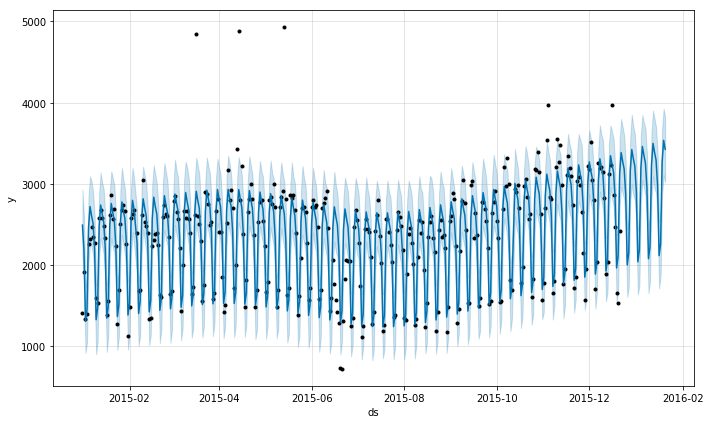

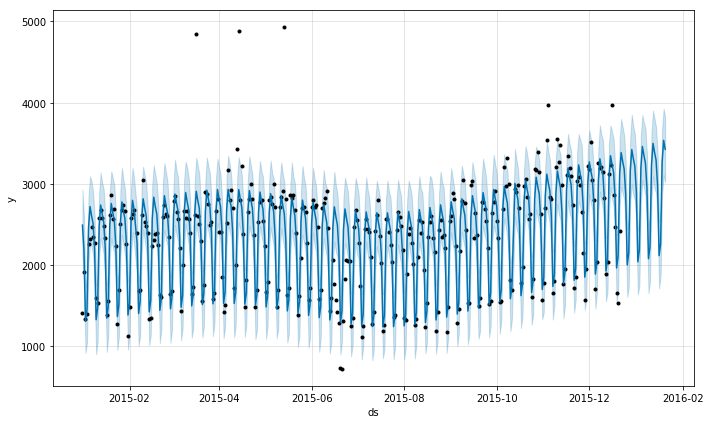

In [11]:
m.plot(forecast)

Estimate the quality of the prediction with the last 30 points.

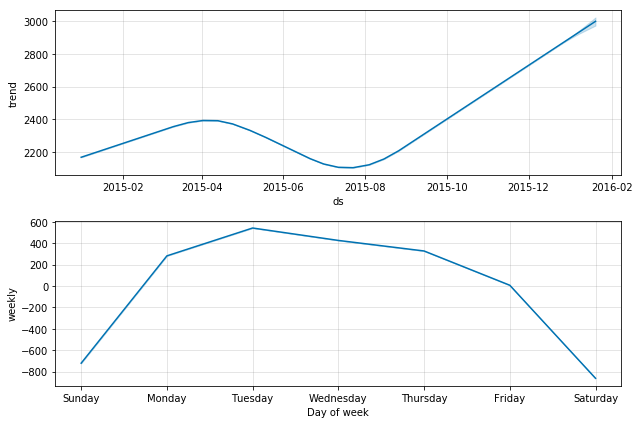

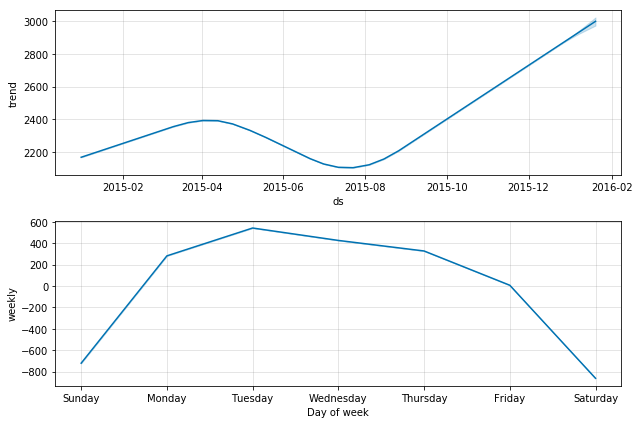

In [12]:
m.plot_components(forecast)

In [14]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2493.394569,2114.364555,2928.754528,1414
2015-01-02,2176.170858,1787.630078,2593.320439,1920
2015-01-03,1310.164121,919.970538,1736.202005,1338
2015-01-04,1453.891639,1047.728880,1878.462476,1404
2015-01-05,2458.694224,2037.770739,2860.828442,2264


In [15]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

MAPE =  34.5
MAE =  599.84


**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600
- 903

## Predicting with ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.107392


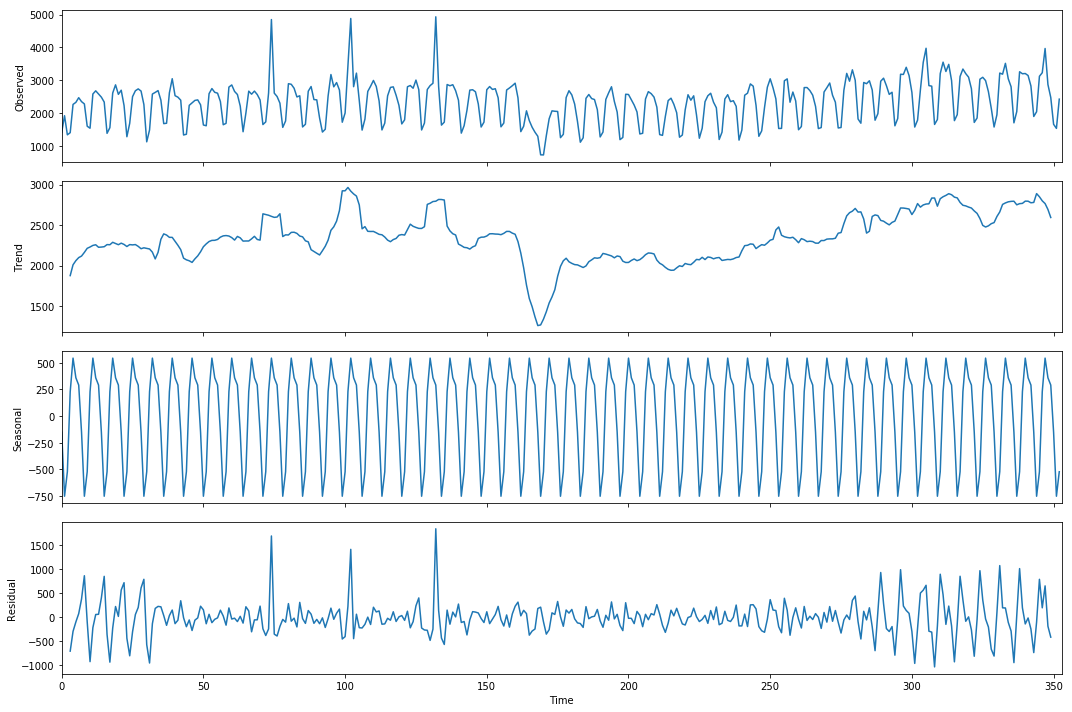

In [17]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

Dickey-Fuller test: p=0.000000


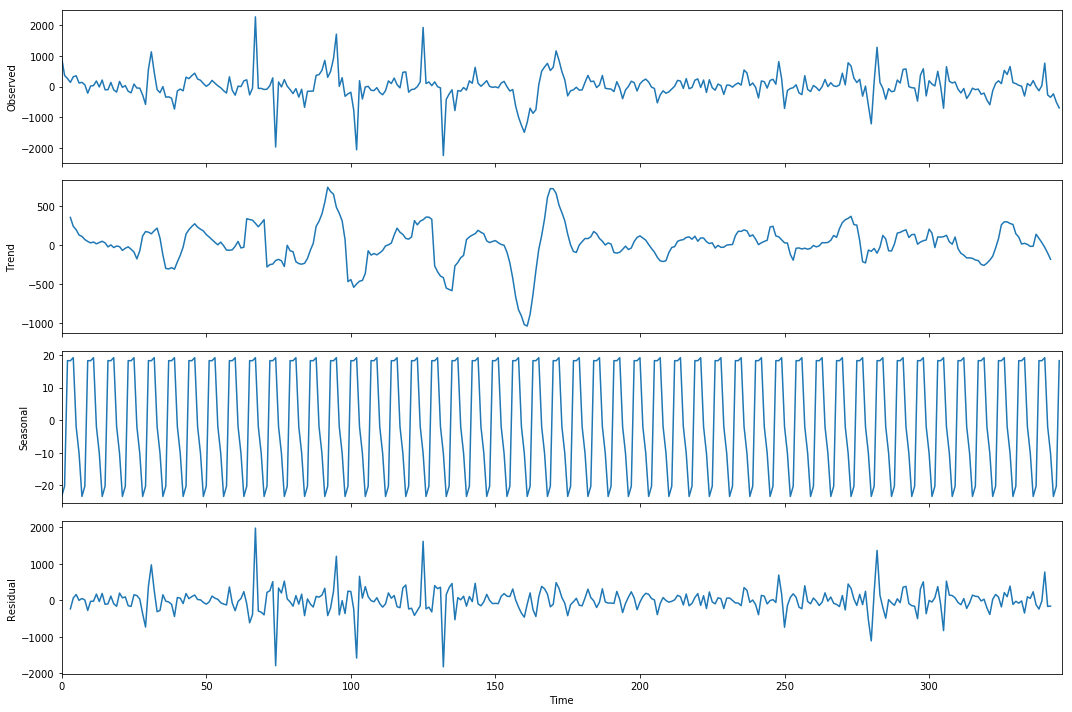

In [18]:
train_df.set_index('ds', inplace=True)
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

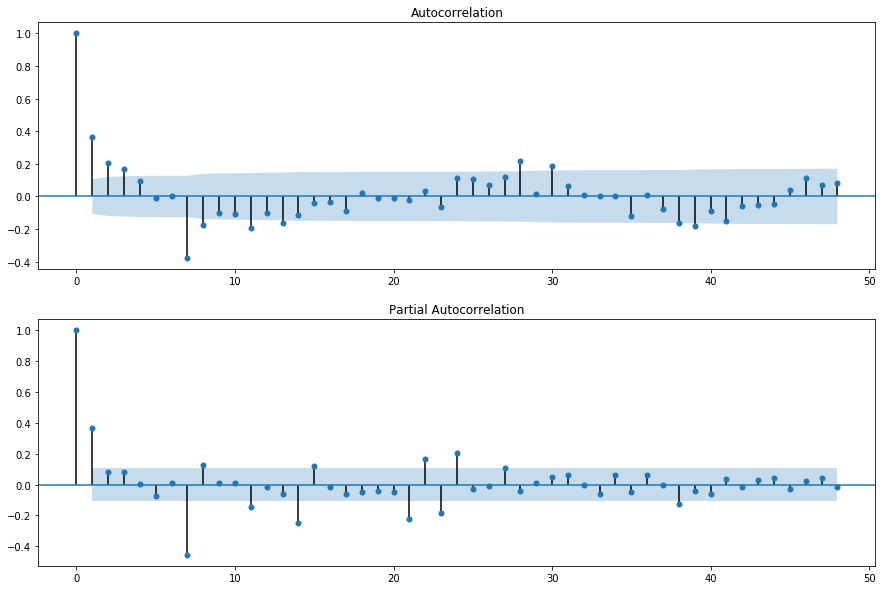

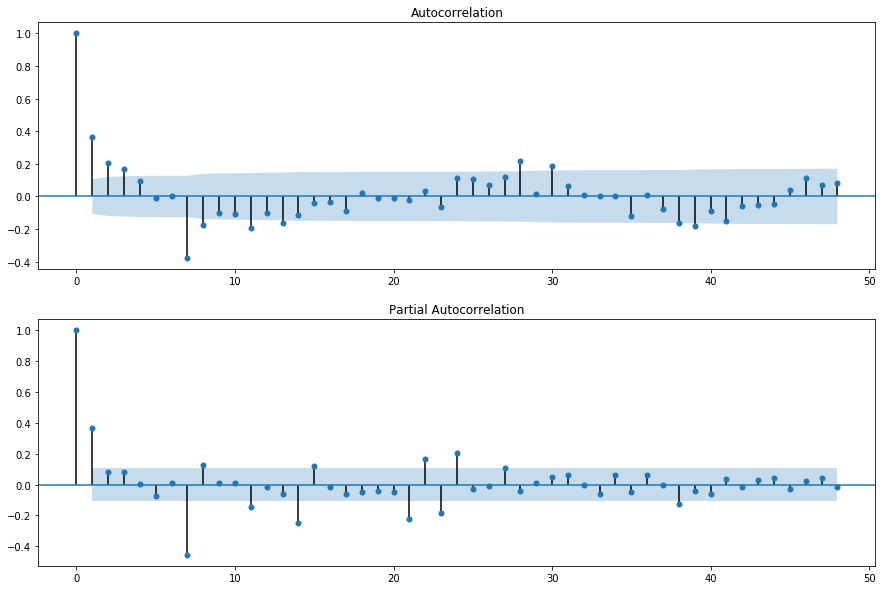

In [19]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

In [20]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [21]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [22]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [08:53<00:00,  1.39s/it]

CPU times: user 17min 49s, sys: 16min 24s, total: 34min 14s
Wall time: 8min 53s


In [23]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
137  (0, 1, 2, 3, 2, 1)  4961.632628
271  (1, 1, 1, 3, 2, 1)  4962.932576
160  (0, 1, 3, 3, 2, 1)  4969.534606
181  (1, 0, 0, 3, 2, 1)  4973.212242
77   (0, 0, 3, 3, 2, 1)  4978.036900


In [24]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
214,"(1, 0, 2, 3, 1, 0)",5022.312524
284,"(1, 1, 2, 3, 1, 1)",5019.555903
286,"(1, 1, 2, 3, 2, 1)",4988.979717


In [25]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [26]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 384/384 [06:51<00:00,  1.07s/it]


In [27]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
223  (1, 0, 2, 3, 2, 1)  3528.650810
181  (1, 0, 0, 3, 2, 1)  3530.524249
202  (1, 0, 1, 3, 2, 1)  3532.092279
276  (1, 1, 1, 3, 2, 1)  3534.434779
291  (1, 1, 2, 3, 2, 1)  3534.540192


In [29]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by='aic', ascending=True).head()

SyntaxError: invalid syntax (<ipython-input-29-18ce784e20bd>, line 4)

In [ ]:
print(best_model.summary())

In [ ]:
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [ ]:
def invboxcox(y,lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [ ]:

train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('wiki pageviews');